<a href="https://colab.research.google.com/github/DanieleAngioni97/ML_Project/blob/master/Adversarial_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install secml

In [17]:
import torch 
import torchvision
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10

loader = CDataLoaderCIFAR10()
_ , ts = loader.load()

# Normalize the data
ts.X /= 255

from secml.ml.features.normalization import CNormalizerMeanStd

trasform = CNormalizerMeanStd(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), with_std=True)
ts_norm = trasform.transform(ts.X)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

path_adversarial = "/content/drive/My Drive/Colab_Notebooks/ML_Project/convnet_saved/"
path_autoencoders = "/content/drive/My Drive/Colab_Notebooks/ML_Project/models_saved/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [10]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict


class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = out_channels
    return nn.Sequential(*layers)


def cifar10(n_channel=128, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel,
           'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(
            'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth')
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

model = cifar10(pretrained=True)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=model,
                         loss=criterion,
                         optimizer=optimizer,
                         pretrained=True,
                         epochs=100,
                         batch_size=64,
                         input_shape=(3, 32, 32),
                         random_state=0)

In [16]:
label_torch = clf.predict(ts_norm, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc_torch = metric.performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.9378


In [ ]:
n_images = 100
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:n_images, :]
#da aummentare

attack_ds_norm = trasform.transform(attack_ds.X)

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, #learning rate
    'eta_min': 2.0, #starting lr
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6 #try 1e-4
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    surrogate_classifier=clf,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
    attack_ds_norm, attack_ds.Y, double_init=True)
print("Attack complete!")

Attack started...
Attack complete!


In [ ]:
print(attack_ds.X)
print(eva_adv_ds.X)

CArray([[0.619608 0.623529 0.647059 ... 0.486275 0.505882 0.431373]])
CArray([[0.619608 0.623529 0.647059 ... 0.486275 0.505882 0.431373]])


In [ ]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import numpy as np
from keras.models import load_model


def create_autoencoder():
 
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------
    #                       DEFINE AUTOENCODER ARCHITECTURE
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------

    input_img = Input(shape=(32, 32, 3))
 
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x) #16x16
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 
    # at this point the representation is (4, 4, 128)
 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #16x16
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #32x32
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
    autoencoder = Model(input_img, decoded)
    
    return autoencoder

model_name = "autoencoderCifar_100.h5"
 
autoencoder = create_autoencoder()
#autoencoder.load_weights(path_autoencoders + model_name)

autoencoder.load_weights('/content/autoencoderCifar_100.h5')

eva_img = eva_adv_ds.X

eva_img_anorm = trasform.inverse_transform(eva_img)

eva_img_anorm_trasformed = eva_img.tondarray().reshape(n_images, 32, 32, 3)

#eva_img_trasformed = np.transpose(eva_img.tondarray().reshape((n_images, 3, 32, 32)), (0, 2, 3, 1))

# eva_img_np = eva_img.tondarray()
# eva_img_np = np.squeeze(eva_img_np)
# eva_img_trasformed = eva_img_np.reshape(32, 32, 3)


decoded_imgs = autoencoder.predict(eva_img_anorm_trasformed)

In [ ]:
print(eva_img_np.shape)
#print(eva_img)


(3072,)


In [ ]:
from secml.array import CArray

decoded_imgs_trasformed = CArray(decoded_imgs.reshape(eva_img.shape))

decoded_imgs_trasformed_normalized = trasform.transform(decoded_imgs_trasformed)

y_pred_clean = clf.predict(decoded_imgs_trasformed_normalized)
acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds_trasform))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)
acc_attack_clean = metric.performance_score(
    y_true=attack_ds.Y, y_pred=y_pred_clean)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))
print("Accuracy on reduced test set after attack and cleaning the images: {:.2%}".format(acc_attack_clean))

Accuracy on reduced test set before attack: 94.00%
Accuracy on reduced test set after attack: 94.00%
Accuracy on reduced test set after attack and cleaning the images: 15.00%


2020-07-23 12:25:55,881 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


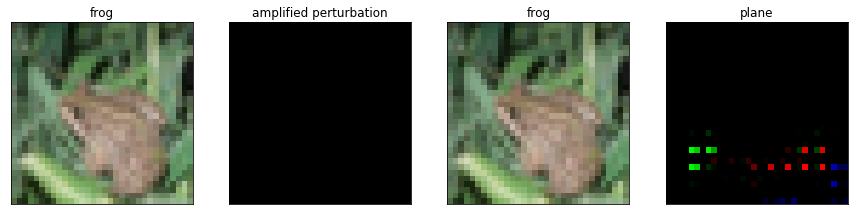

In [ ]:
from secml.figure import CFigure
%matplotlib inline
k=4

start_img_k = attack_ds.X[k,:]
eva_img_anorm_k = eva_img_anorm[k,:]

# normalize perturbation for visualization
diff_img_k = start_img_k - eva_img_anorm_k
#diff_img -= diff_img.min()
#diff_img /= diff_img.max()

decode_img_k = decoded_imgs[k,:]

import numpy as np
start_img_k = np.transpose(start_img_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))
diff_img_k = np.transpose(diff_img_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))
eva_img_anorm_k = np.transpose(eva_img_anorm_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))

image_clear_k = np.transpose(decode_img_k.reshape((3, 32, 32)), (1, 2, 0))

fig = CFigure(width=15, height=5)
fig.subplot(1, 4, 1)
fig.sp.imshow(start_img_k)
fig.sp.title(classes[attack_ds.Y[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 4, 2)
fig.sp.imshow(diff_img_k)
fig.sp.title("amplified perturbation")
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 4, 3)
fig.sp.imshow(eva_img_anorm_k)
fig.sp.title(classes[eva_y_pred[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])


fig.subplot(1, 4, 4)
fig.sp.imshow(image_clear_k)
fig.sp.title(classes[y_pred_clean[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])

fig.show()


In [ ]:
print(eva_img_anorm.shape)
print(start_img.shape)
print(eva_img.shape)

(1, 3072)
(32, 32, 3)
(32, 32, 3)


In [ ]:
acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 100.00%


Running security evaluation...
Finish security evaluation...


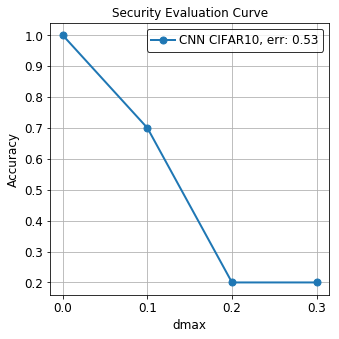

In [ ]:
# Perturbation levels to test
e_vals = CArray.arange(start=0, step=0.1, stop=0.4)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(attack_ds, double_init=False)
print("Finish security evaluation...")
 
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='CNN CIFAR10', show_average=True)
fig.show()

Running security evaluation...
Finish security evaluation...


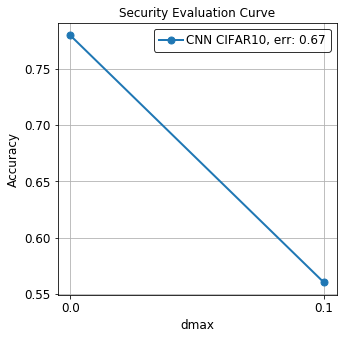

In [ ]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=0.2)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals, save_adv_ds=True)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(attack_ds, double_init=False)
print("Finish security evaluation...")
 
from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='CNN CIFAR10', show_average=True)
fig.show()

In [ ]:
print(sec_eval.sec_eval_data.adv_ds)

#sec_eval_data_trasformed = sec_eval.sec_eval_data.tondarray().reshape(n_images, 32, 32, 3)
#decoded_imgs = autoencoder.predict(sec_eval_data_trasformed)


[CDataset{'X': CArray(100, 3072)(dense: [[0.619608 0.623529 0.647059 ... 0.486275 0.505882 0.431373] [0.921569 0.905882 0.909804 ... 0.698039 0.74902  0.780392] [0.619608 0.619608 0.545098 ... 0.031373 0.011765 0.027451] ... [0.517647 0.521569 0.529412 ... 0.564706 0.560784 0.560784] [1.       1.       1.       ... 1.       1.       1.      ] [0.917647 0.933333 0.937255 ... 0.490196 0.537255 0.498039]]), 'Y': CArray(100,)(dense: [3 8 8 ... 0 0 7]), 'header': None}, CDataset{'X': CArray(100, 3072)(dense: [[0.619535 0.623385 0.646406 ... 0.486371 0.505857 0.431614] [0.921494 0.905791 0.910099 ... 0.698209 0.749084 0.780307] [0.619546 0.619852 0.545286 ... 0.030853 0.012325 0.027537] ... [0.51758  0.52148  0.5293   ... 0.564778 0.56081  0.560797] [0.999994 1.       1.       ... 0.999955 1.       1.      ] [0.917557 0.933357 0.937993 ... 0.489952 0.537263 0.497977]]), 'Y': CArray(100,)(dense: [3 8 8 ... 0 0 7]), 'header': None}]


Attack with 0.0 started...
Attack complete!
Attack with 0.1 started...
Attack complete!
Attack with 0.2 started...
Attack complete!
Attack with 0.3 started...
Attack complete!
Attack with 0.4 started...
Attack complete!
Attack with 0.5 started...
Attack complete!
Attack with 0.6 started...
Attack complete!
Attack with 0.7 started...
Attack complete!
Attack with 0.8 started...
Attack complete!
Attack with 0.9 started...
Attack complete!
Attack with 1.0 started...
Attack complete!


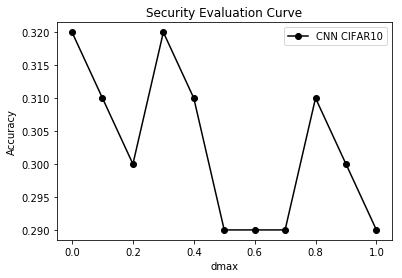

In [ ]:
from secml.adv.attacks import CAttackEvasionPGDLS
n_images = 100
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:n_images, :]
#da aummentare

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'

lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, #learning rate
    'eta_min': 2.0, #starting lr
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6 #try 1e-4
}

dmax_max = 1.1  # Maximum perturbation
v_dmax = np.arange(0, dmax_max, 0.1)
idx_max = v_dmax.size
v_acc_attack_clean = np.zeros(idx_max)

for i in range(0,idx_max):
      dmax = v_dmax[i]
      pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    surrogate_classifier=clf,
                                    surrogate_data=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)
      
      print("Attack with dmax %.1f started..." %(dmax))
      eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(
          attack_ds.X, attack_ds.Y, double_init=True)
      print("Attack complete!")

      eva_img = eva_adv_ds.X
      eva_img_trasformed = eva_img.tondarray().reshape(n_images, 32, 32, 3)
      decoded_imgs = autoencoder.predict(eva_img_trasformed)

      decoded_imgs_trasformed = CArray(decoded_imgs.reshape(eva_img.shape))
      y_pred_clean = clf.predict(decoded_imgs_trasformed)

      acc_attack_clean = metric.performance_score(
          y_true=attack_ds.Y, y_pred=y_pred_clean)
      
      v_acc_attack_clean[i] = acc_attack_clean

plt.plot(v_dmax,v_acc_attack_clean, 'b', marker='o')
plt.xlabel('dmax')
plt.ylabel('Accuracy')
plt.title('Security Evaluation Curve')
plt.legend(['CNN CIFAR10'], loc='upper right')
plt.show()

In [ ]:
print(v_acc_attack_clean)

[0.32 0.31 0.3  0.32 0.31 0.29 0.29 0.29 0.31 0.3  0.29]
